In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
def calculate_eddy(width=500000, num_depth_layers=21, eta0=1, L=1e5, H=1000, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0., alpha_2=0., T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, temperature, salinity, 
    and pressure fields for an ocean eddy.

    Parameters:
    - width: Horizontal extent of the grid (eddy scale) in meters.
    - num_depth_layers: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a, b: Coefficients affecting density anomaly variation.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -34 degrees.
    - alpha_1, alpha_2: Coefficients affecting eddy center shift with depth.
    - T0: Surface temperature (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    - dSdz: Salinity gradient with depth (psu per meter).
    - taper_depth: Tapering scale for vertical variations.

    Returns:
    - U, V: 3D matrices for the U and V (x- and y-components) velocity fields.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - S: 3D matrix for the salinity field.
    - P: 3D matrix for the pressure field.
    - x, y, z: Horizontal and vertical grid points.
    """

    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))  # Coriolis parameter for latitude -34 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)

    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-width // 2, width // 2, 101)  # x-coordinates
    y = np.linspace(-width // 2, width // 2, 101)  # y-coordinates
    z = np.linspace(-H, 0, num_depth_layers)  # Depth levels from surface (0) to -H

    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

    if taper_depth is None:
        taper_factor = np.ones_like(z_3d)
    else:
        taper_factor = np.exp(z_3d / taper_depth)

    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)

    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d

    # Calculate radial distance r - r_c(z)
    r_c = np.hypot( x_3d - x_c, y_3d - y_c )

    # Temperature field
    # T = T0 + dTdz * z_3d - 2 * f_r_rc(r_c, L) * taper_factor
    T = - 2 * f_r_rc(r_c, L) * taper_factor

    # Salinity field
    S0 = 35  # Reference surface salinity (psu)
    # S = S0 + dSdz * z_3d + 1.5 * f_r_rc(r_c, L) * taper_factor
    S = 1.5 * f_r_rc(r_c, L) * taper_factor

    # Pressure field (hydrostatic pressure)
    P = -rho0 * g * z_3d

    # Density field using a simplified equation of state
    alpha = 0.0002  # Thermal expansion coefficient (1/°C)
    beta = 0.0008  # Haline contraction coefficient (1/psu)
    sigma = rho0 * (1 - alpha * (T - T0) + beta * (S - S0)) 
    sigma -= np.mean(sigma)

    # Calculate geostrophic velocity components
    dx = x[1] - x[0]  # Grid spacing in x
    dy = y[1] - y[0]  # Grid spacing in y
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy

    U = g / f0 * d_sigma_dy * taper_factor
    V = -g / f0 * d_sigma_dx * taper_factor

    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    T = np.flip(T, axis=2)
    S = np.flip(S, axis=2)
    P = np.flip(P, axis=2)
    z = np.flip(z)

    return U, V, sigma, T, S, P, x, y, z


In [3]:
def nencioli(u, v, lon, lat, a, b): #,var
    """
    Identify the points in the domain which satisfy the four velocity constraints for eddy detection.

    Parameters:
    - u, v: 2D velocity fields for u and v components
    - lon, lat: Longitude and Latitude matrices
    - mask: Matrix defining sea (1) and land points (0)
    - a, b: Parameters used for constraints

    Returns:
    - eddy_uv: Positions that satisfy the first two constraints (for debugging)
    - eddy_c: Positions satisfying the first three constraints (for debugging)
    - eddy: Positions of the eddy centers with their type (cyclonic=1, anticyclonic=-1)
    """

    borders = max(a, b) + 1

    # Compute velocity magnitude
    vel = np.sqrt(u**2 + v**2)

    # Initialize arrays for storing eddy centers
    eddy_uv = np.zeros((0, 2))
    eddy_c = np.zeros((0, 2))
    eddy = np.zeros((0, 3))

    # Get domain dimensions
    bound = vel.shape

    # Loop through each latitudinal section
    for i in range(borders, len(v) - borders + 1):
        wrk = v[i, :]  # Latitudinal section of v

        # First constraint: zero crossing in v component
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        indx = indx[(indx >= borders) & (indx < len(wrk) - borders)]

        for ii in indx:
            var = 0  # Eddy type (0 = no eddy, 1 = cyclonic, -1 = anticyclonic)
            if wrk[ii] >= 0:  # Anticyclonic
                if wrk[ii - a] > wrk[ii] and wrk[ii + 1 + a] < wrk[ii + 1]:
                    var = -1
            elif wrk[ii] < 0:  # Cyclonic
                if wrk[ii - a] < wrk[ii] and wrk[ii + 1 + a] > wrk[ii + 1]:
                    var = 1

            # Second constraint: u component reversal
            if var != 0:
                if var == -1:
                    if (u[i - a, ii] <= 0 and u[i - a, ii] <= u[i - 1, ii] and
                        u[i + a, ii] >= 0 and u[i + a, ii] >= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                elif var == 1:
                    if (u[i - a, ii] >= 0 and u[i - a, ii] >= u[i - 1, ii] and
                        u[i + a, ii] <= 0 and u[i + a, ii] <= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0

                # Third constraint: velocity minimum
                if var != 0:
                    srch = vel[i - b:i + b, ii - b:ii + b + 1]
                    slat = lat[i - b:i + b, ii - b:ii + b + 1]
                    slon = lon[i - b:i + b, ii - b:ii + b + 1]
                    X, Y = np.unravel_index(np.argmin(srch), srch.shape)
                    srch2 = vel[max(i - b + X - 1 - b, 0):min(i - b + X - 1 + b, bound[0]),
                                max(ii - b + Y - 1 - b, 0):min(ii - b + Y - 1 + b, bound[1])]

                    if np.min(srch2) == np.min(srch):
                        eddy_c = np.vstack([eddy_c, [slat[X, Y], slon[X, Y]]])
                    else:
                        var = 0

                # Fourth constraint: vector rotation (simplified version)
                d = a - 1
                if var != 0:
                    # Find indices of the estimated center in the large domain
                    i1, i2 = np.where((lat == slat[X, Y]) & (lon == slon[X, Y]))

                    i1, i2 = int(i1[0]), int(i2[0])
                    
                    # Extract velocities within "a-1" points from the estimated center
                    u_small = u[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    v_small = v[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    
                    # Apply constraint only if there are no NaNs in u_small
                    if not np.isnan(u_small).any():
                        # Boundary velocities
                        u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                        v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])

                        # Vector defining which quadrant each boundary vector belongs to
                        quadrants = np.zeros_like(u_bound)
                        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4
                        
                        # Identify the first fourth quadrant vector
                        spin = np.where(quadrants == 4)[0]
                        
                        # Apply the constraint only if the rotation is complete and not all vectors are in the fourth quadrant
                        if spin.size > 0 and spin.size != quadrants.size:
                            # If vectors start in the 4th quadrant, add 4 to all quadrant positions after the first occurrence
                            if spin[0] == 0:
                                spin = np.where(quadrants != 4)[0]
                                spin = spin[0] - 1
                                
                            if not isinstance(spin, np.ndarray):
                                spin = np.array([int(spin)])
                            quadrants[spin[-1] + 1:] += 4
                            
                            # Inspect vector rotation: no consecutive vectors should be more than one quadrant apart
                            # and there should be no backward rotation
                            if not np.any(np.diff(quadrants) > 1) and not np.any(np.diff(quadrants) < 0):
                                eddy = np.vstack([eddy, [slat[X, Y], slon[X, Y], var]])


    # Process eddy results (sorting and removing duplicates)
    eddy = np.unique(eddy, axis=0)
    eddy_uv = np.unique(eddy_uv, axis=0)
    eddy_c = np.unique(eddy_c, axis=0)

    # Adjust for the Southern Hemisphere (flip cyclonic/anticyclonic labels)
    # eddy[eddy[:, 0] < 0, 2] = -eddy[eddy[:, 0] < 0, 2]
    eddy[:, 2] = -eddy[:, 2]

    return eddy_uv, eddy_c, eddy

def moca(u1, v1, u2, v2, n_ic, n_jc, dx):

    def domain_finder(lst, ic, cyc, vel_vec):
        def find_local_extrema(data):
            minima = [i for i in range(1, len(data) - 1) if data[i - 1] > data[i] < data[i + 1]]
            maxima = [i for i in range(1, len(data) - 1) if data[i - 1] < data[i] > data[i + 1]]
            return np.array(minima), np.array(maxima)
    
        minima, maxima = find_local_extrema(lst)
        minima = np.array([m for m in minima if lst[m] <= 0])
        maxima = np.array([m for m in maxima if lst[m] >= 0])
    
        condition = (cyc == 'CE' and vel_vec == 'v') or (cyc == 'AE' and vel_vec == 'u')
        valid_maxima = maxima[maxima <= ic] if condition else maxima[maxima >= ic]
        valid_minima = minima[minima >= ic] if condition else minima[minima <= ic]
    
        domain_max = valid_maxima[np.argmin(np.abs(valid_maxima - ic))]
        domain_min = valid_minima[np.argmin(np.abs(valid_minima - ic))]
        
        start, end = sorted((domain_min, domain_max))
        indices = np.arange(start, end + 1)

        return np.array(lst[start:end + 1]), indices
        
    u2, u_ind = domain_finder(u2, n_jc, cyc=cyc, vel_vec='u')
    v2 = v2[u_ind]

    yy = (np.array(u_ind) - n_jc) * dx

    v1, v_ind = domain_finder(v1, n_ic, cyc=cyc, vel_vec='v')
    u1 = u1[v_ind]
    xx = (np.array(v_ind) - n_ic) * dx

    def fit_cubic_and_tangent(x, y):
        cubic = np.poly1d(np.polyfit(x, y, 3))
        cubic_deriv = np.polyder(cubic)
        roots = np.roots(cubic)
        valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
    
        if valid_roots.size:
            root = valid_roots[0]
            slope, intercept = cubic_deriv(root), -cubic_deriv(root) * root
        else:
            return 0, np.sign(y[np.argmax(np.abs(y))]) * np.max(np.abs(y)), 0
    
        r_squared = 1 - np.sum((y - cubic(x))**2) / np.sum((y - np.mean(y))**2)
        return slope, intercept, r_squared

    A1, A0, r2A = fit_cubic_and_tangent(xx, u1)
    B1, B0, r2B = fit_cubic_and_tangent(xx, v1)
    C1, C0, r2C = fit_cubic_and_tangent(yy, u2)
    D1, D0, r2D = fit_cubic_and_tangent(yy, v2)

    alpha = A0 if r2A > r2C else C0
    beta = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
    Q = np.array([[q11, q12], [q12, q22]])
    
    def is_pos_def(Q):
        eigenvalues = np.linalg.eigvals(Q)
        return np.all(eigenvalues > 0)
    if is_pos_def(Q) or is_pos_def(-Q):
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))  
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))      
        w = 2 * (q11 + q22)
    else:
        xc = yc = np.nan

    return xc, yc, xx, yy, w


In [4]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None)

U_tap, V_tap, sigma_tap, T_tap, S_tap, P_tap, _, _, _ = calculate_eddy(taper_depth=400)

dx, dy, dz = x[1] - x[0], y[1] - y[0], z[1]-z[0]

alpha_1 = dx / dz # tilt in x direction

U_tilt, V_tilt, sigma_tilt, T_tilt, S_tilt, P_tilt, _, _, _ = calculate_eddy(taper_depth=None, alpha_1=alpha_1)

U_tilt_tap, V_tilt_tap, sigma_tilt_tap, T_tilt_tap, S_tilt_tap, P_tilt_tap, _, _, _ = calculate_eddy(taper_depth=400, alpha_1=alpha_1)


In [5]:
modelled_data = {
    'Eddy0':{
        'Name': 'E1', 'U': U, 'V': V, 'sigma': sigma, 'T': T, 'S': S, 'P': P
    },
    'Eddy1':{
        'Name': r'E1$_\text{tap}$', 'U': U_tap, 'V': V_tap, 'sigma': sigma_tap, 'T': T_tap, 'S': S_tap, 'P': P_tap
    },
    'Eddy2':{
        'Name': 'E2', 'U': U_tilt, 'V': V_tilt, 'sigma': sigma_tilt, 'T': T_tilt, 'S': S_tilt, 'P': P_tilt
    },
    'Eddy3':{
        'Name': r'E2$_\text{tap}$', 'U': U_tilt_tap, 'V': V_tilt_tap, 'sigma': sigma_tilt_tap, 'T': T_tilt_tap, 'S': S_tilt_tap, 'P': P_tilt_tap
    },
    'x': x, 'y': y, 'z': z
}
eddies = ['Eddy0', 'Eddy1', 'Eddy2', 'Eddy3']

In [6]:
a, b = 4, 3
MAX_DISPLACEMENT = 50000
var = 1  # Cyclonic
plot_data = {}

x, y = modelled_data['x'], modelled_data['y']
X, Y = np.meshgrid(x, y)

for eddy in eddies:
    plot_data[eddy] = {
        'df': pd.DataFrame(columns=['n_xc', 'n_yc', 'xc', 'yc', 'Depth', 'Vort'])
    }
    xc_pre, yc_pre = 0, 0 
    bottom_flag = True
    U, V = modelled_data[eddy]['U'], modelled_data[eddy]['V']

    for depth_lvl in range(U.shape[-1]):
        if not bottom_flag:
            break

        u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
        neddy_uv, neddy_c, neddy = nencioli(u.T, v.T, X, Y, a, b)

        neddy = neddy[neddy[:, 2] == var]
        if len(neddy[:, 1]) > 1:
            R = np.hypot(neddy[:, 1], neddy[:, 0]) if depth_lvl == 0 else \
                np.hypot(xc_pre - neddy[:, 1], yc_pre - neddy[:, 0])
            neddy = neddy[R == np.nanmin(R)]

        if len(neddy[:, 1]) == 1:
            n_xc, n_yc = neddy[0, 1], neddy[0, 0]
            n_ic, n_jc = np.where(n_xc == x)[0][0], np.where(n_yc == y)[0][0]

            u1, v1 = u[:, n_jc].squeeze(), v[:, n_jc].squeeze()
            u2, v2 = u[n_ic, :].squeeze(), v[n_ic, :].squeeze()

            cyc = 'CE' if var == 1 else 'AE'
            xc, yc, xx, yy, w = moca(u1, v1, u2, v2, n_ic, n_jc, dx, cyc)

            xc = n_xc + xc
            yc = n_yc + yc

            R = MAX_DISPLACEMENT - 10 if depth_lvl == 0 else \
                np.hypot(xc_pre - xc, yc_pre - yc)

            xc_pre = xc
            yc_pre = yc

            if R <= MAX_DISPLACEMENT:
                plot_data[eddy]['df'].loc[len(plot_data[eddy]['df'])] = {
                    'n_xc': n_xc,
                    'n_yc': n_yc,
                    'xc': xc,
                    'yc': yc,
                    'Depth': z[depth_lvl],
                    'Vort': w,
                }

                plot_data[eddy][f'x{depth_lvl}'] = xx
                plot_data[eddy][f'y{depth_lvl}'] = yy
            else:
                bottom_flag = False
        else:
            bottom_flag = False

plot_data[eddy]['df']

,n_xc,n_yc,xc,yc,Depth,Vort
0,0.0,0.0,0.0,0.0,0.0,-7.669063e-05
1,5000.0,0.0,5000.0,0.0,-50.0,-5.972672e-05
2,10000.0,0.0,10000.0,0.0,-100.0,-4.651522e-05
3,15000.0,0.0,15000.0,0.0,-150.0,-3.622609e-05
4,20000.0,0.0,20000.0,0.0,-200.0,-2.821291e-05
5,25000.0,0.0,25000.0,0.0,-250.0,-2.197223e-05
6,30000.0,0.0,30000.0,0.0,-300.0,-1.711199e-05
7,35000.0,0.0,35000.0,0.0,-350.0,-1.332683e-05
8,40000.0,0.0,40000.0,0.0,-400.0,-1.037895e-05
9,45000.0,0.0,45000.0,0.0,-450.0,-8.083133e-06


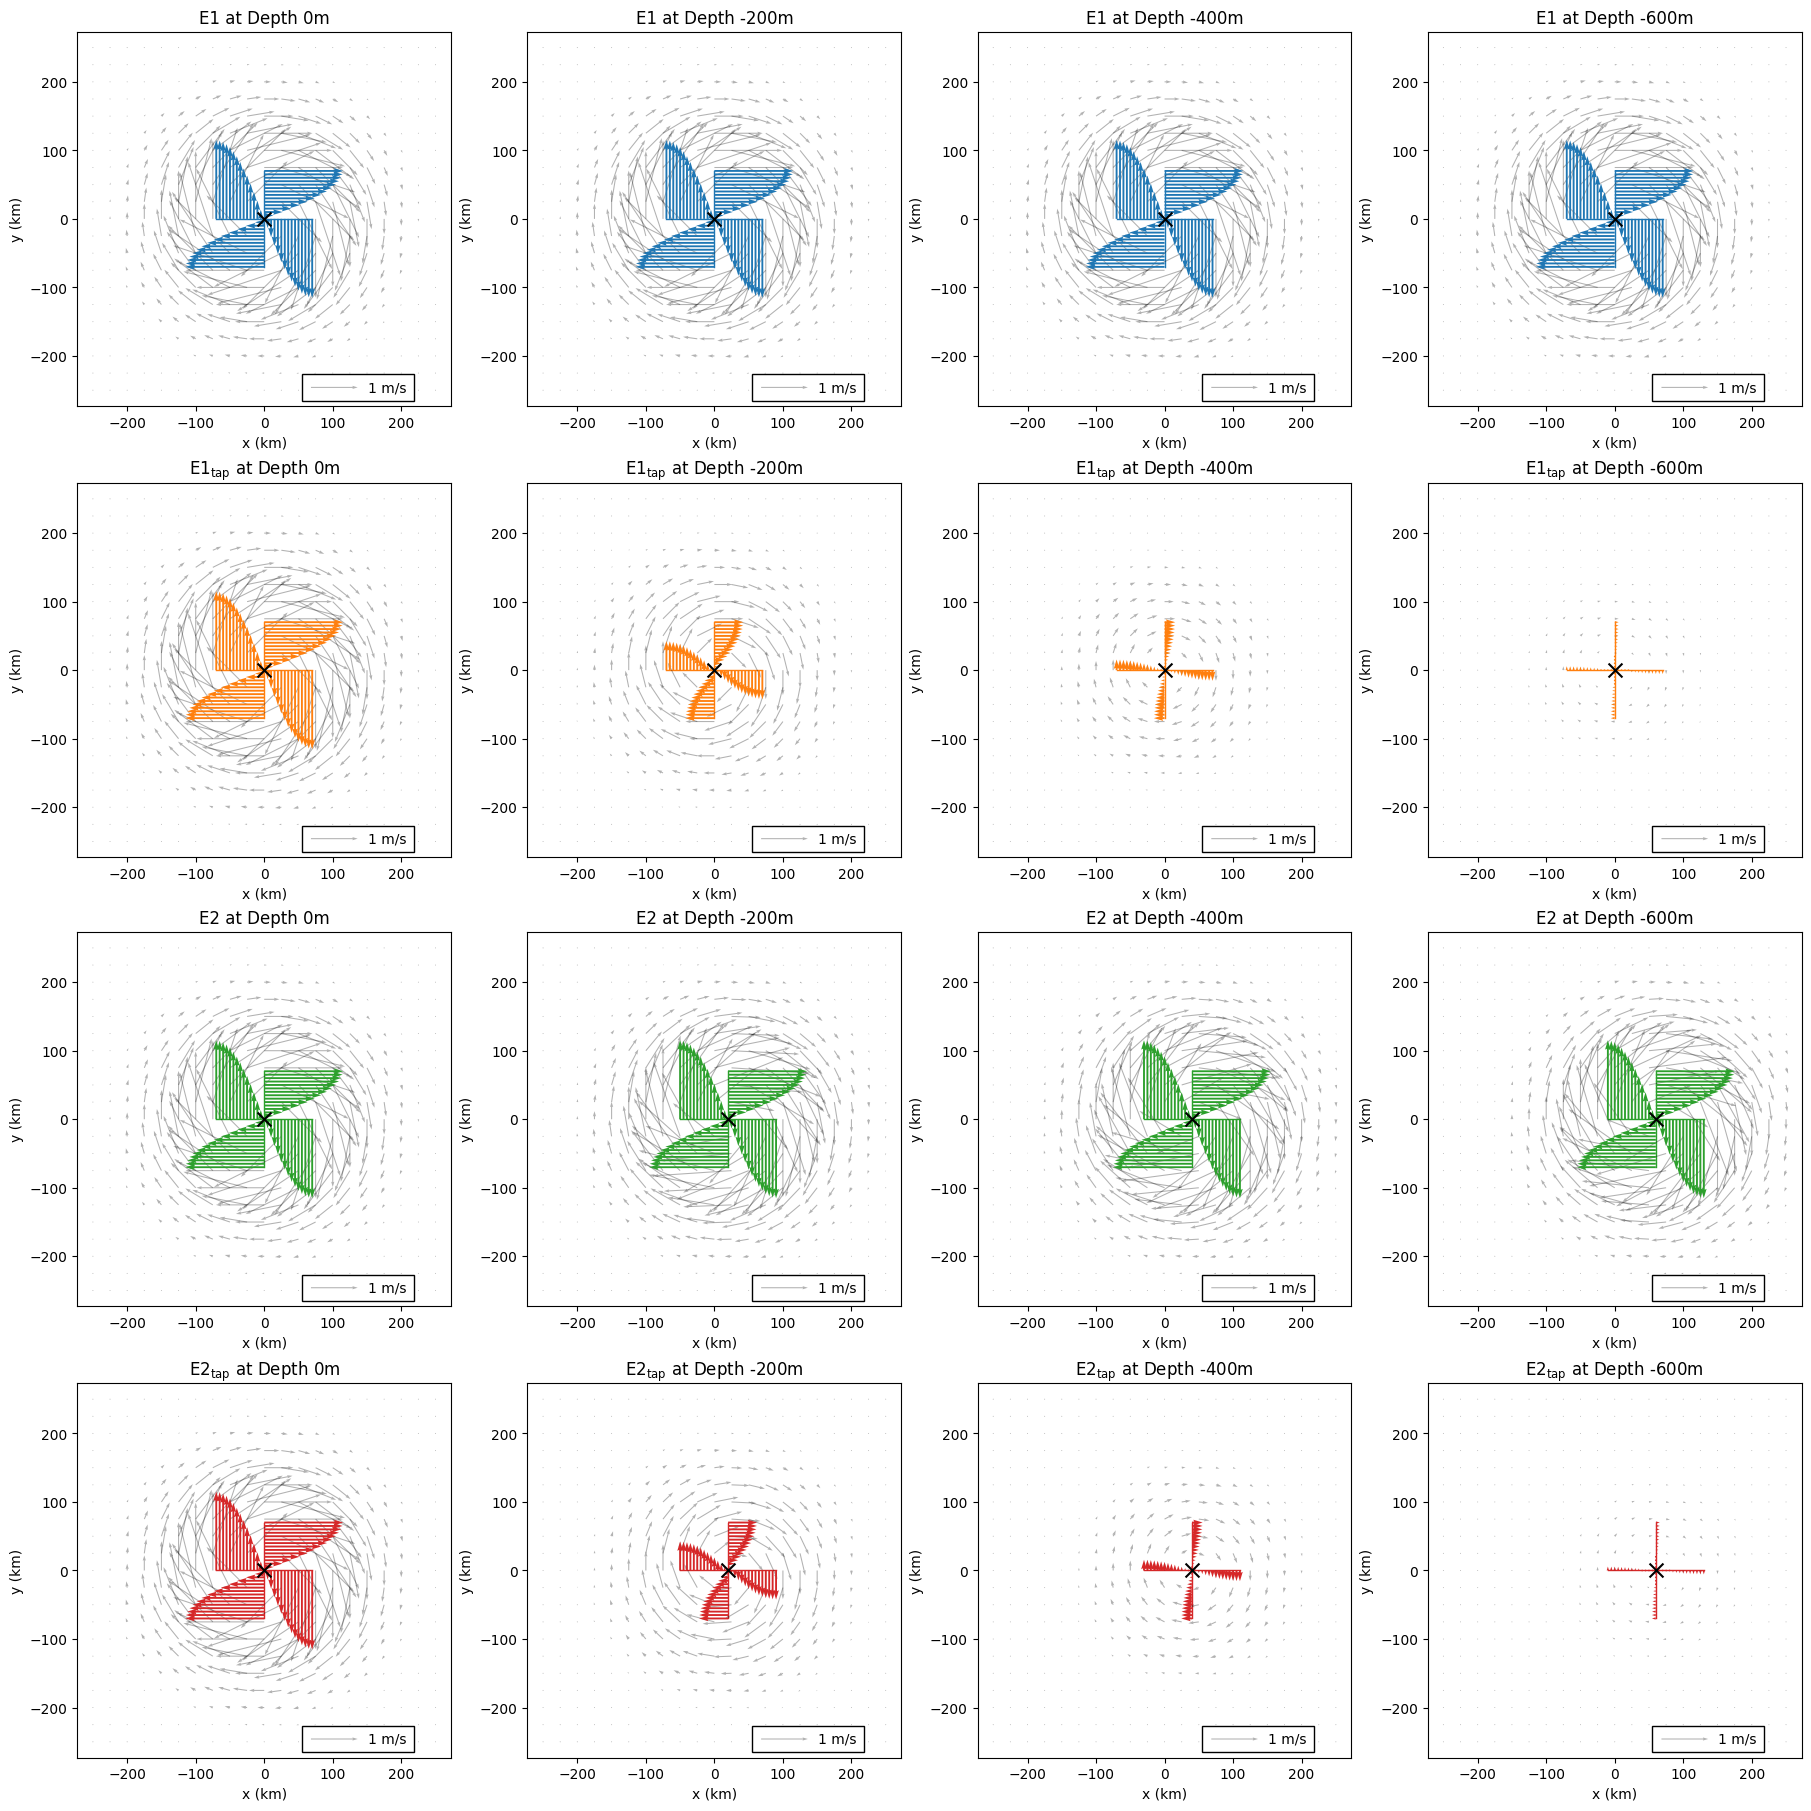

In [7]:
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(4, 4, figsize=(18, 18), constrained_layout=True)#, sharex=True, sharey=True)
for r, eddy in enumerate(eddies):
    
    depth_lvls = [0, 4, 8, 12]
    
    scale_factor = [8, 8, 8, 8]
    colors = plt.cm.tab10.colors * 3
    
    for i, depth_lvl in enumerate(depth_lvls):
        ax = axes[r, i]
        
        u = modelled_data[eddy]['U'][:, :, depth_lvl]
        v = modelled_data[eddy]['V'][:, :, depth_lvl]
        x = modelled_data['x']/1000
        y = modelled_data['y']/1000
        z = modelled_data['z']
        name = modelled_data[eddy]['Name']
        
        X, Y = np.meshgrid(x, y)
        spacing = 5
        quiv = ax.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
                  u[::spacing, ::spacing].T, v[::spacing, ::spacing].T,
                  alpha=0.3, scale=scale_factor[i])
        data = plot_data[eddy]['df'].iloc[depth_lvl]
        n_xc = data['n_xc'] / 1000
        n_yc = data['n_yc'] / 1000
        xc = data['xc'] / 1000
        yc = data['yc'] / 1000
        xx = plot_data[eddy]['x'+str(depth_lvl)] / 1000
        yy = plot_data[eddy]['y'+str(depth_lvl)] / 1000
        
        ix = np.where(np.isin(x, xx + n_xc))[0]
        jy = np.where(np.isin(y, yy + n_yc))[0]
        i_nenc = np.where(n_xc == x)[0]
        j_nenc = np.where(n_yc == y)[0]
        iu = u[ix, j_nenc]
        iv = v[ix, j_nenc]
        ju = u[i_nenc, jy]
        jv = v[i_nenc, jy]
        
        spacing = 1
        ax.quiver(xx[::spacing] + n_xc, [n_yc] * len(xx[::spacing]),
                  iu[::spacing], iv[::spacing], color=colors[r], scale=scale_factor[i], width=0.005)
        ax.quiver([n_xc] * len(yy[::spacing]), yy[::spacing] + n_yc,
                  ju[::spacing], jv[::spacing], color=colors[r], scale=scale_factor[i], width=0.005)
        ax.plot(xx + n_xc, [n_yc] * len(xx), zorder=0, linewidth=1, color=colors[r])
        ax.plot([n_xc] * len(yy), yy + n_yc, zorder=0, linewidth=1, color=colors[r])
        ax.scatter(xc, yc, marker='x', s=100, color='k')
        
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
        ax.set_title(name+' at Depth '+str(round(z[depth_lvl]))+'m')

        if np.any(np.isnan(u)) and r != 1:
            nan_mask = np.isnan(u)
            mask = np.where(~np.isnan(u), np.nan, 0)
            ax.contourf(x, y, mask.T, cmap='gray', zorder=-1)
            ax.contour(x, y, nan_mask.T, colors='k', linewidths=2, alpha=.5)

        magnitude = 1
        x_pos, y_pos = 0.75, 0.05  
        box_width = 0.3  # Adjust width as needed
        box_height = 0.07  # Adjust height as needed
        rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                               box_width, box_height, transform=ax.transAxes,
                               facecolor='white', edgecolor='black')
        ax.add_patch(rect)
        ax.quiverkey(quiv, X=x_pos, Y=y_pos, U=magnitude,
                     label=f'{magnitude} m/s', labelpos='E')
        ax.axis('equal')
plt.show()

In [14]:
plot_data['Eddy3']['df'].diff() # why is it shifting!!!

,n_xc,n_yc,xc,yc,Depth,Vort
0,NaN,NaN,NaN,NaN,NaN,NaN
1,5000.0,0.0,5000.0,0.0,-50.0,1.696391e-05
2,5000.0,0.0,5000.0,0.0,-50.0,1.321150e-05
3,5000.0,0.0,5000.0,0.0,-50.0,1.028913e-05
4,5000.0,0.0,5000.0,0.0,-50.0,8.013182e-06
5,5000.0,0.0,5000.0,0.0,-50.0,6.240673e-06
6,5000.0,0.0,5000.0,0.0,-50.0,4.860241e-06
7,5000.0,0.0,5000.0,0.0,-50.0,3.785159e-06
8,5000.0,0.0,5000.0,0.0,-50.0,2.947885e-06
9,5000.0,0.0,5000.0,0.0,-50.0,2.295815e-06


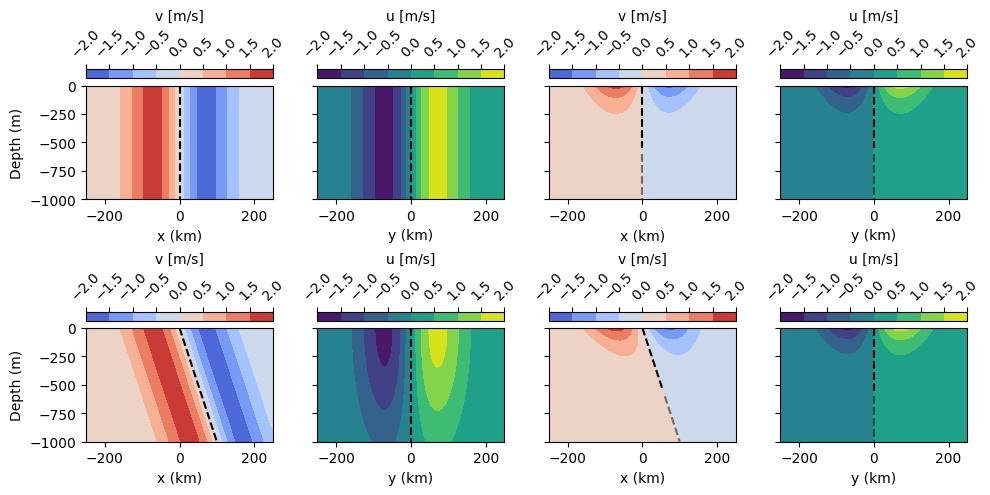

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
x = modelled_data['x']/1000
y = modelled_data['y']/1000
for i, ax_pair in enumerate(axs.reshape(-1, 2)):
    eddy = eddies[i]
    U = modelled_data[eddy]['U'][modelled_data[eddy]['U'].shape[0] // 2, :, :]
    V = modelled_data[eddy]['V'][:, modelled_data[eddy]['V'].shape[1] // 2, :]

    im1 = ax_pair[0].contourf(x, z, V.T, cmap='coolwarm')
    im2 = ax_pair[1].contourf(y, z, U.T)

    df = plot_data[eddy]['df']

    VORT_THRESH = -0.000006
    mask = df['Vort'] <= VORT_THRESH
    mask = mask.tolist()
    for i in range(len(mask) - 2, -1, -1):
        if mask[i] and not mask[i + 1]:
            mask[i + 1] = True
            break
    mask = pd.Series(mask)
    ax_pair[0].plot(df.loc[mask, 'xc'] / 1000, df.loc[mask, 'Depth'], 'k', label='VG', alpha=1, linestyle='--')
    ax_pair[0].plot(df.loc[~mask, 'xc'] / 1000, df.loc[~mask, 'Depth'], 'k', alpha=0.5, linestyle='--')
    ax_pair[1].plot(df.loc[mask, 'yc'] / 1000, df.loc[mask, 'Depth'], 'k', label='VG', alpha=1, linestyle='--')
    ax_pair[1].plot(df.loc[~mask, 'yc'] / 1000, df.loc[~mask, 'Depth'], 'k', alpha=0.5, linestyle='--')
        
    ax_pair[0].set_xlabel('x (km)')
    ax_pair[1].set_xlabel('y (km)')

    cbar1 = fig.colorbar(im1, ax=ax_pair[0], orientation='horizontal', location='top', label='v [m/s]')
    cbar2 = fig.colorbar(im2, ax=ax_pair[1], orientation='horizontal', location='top', label='u [m/s]')

    # Rotate colorbar ticks
    cbar1.ax.tick_params(axis='x', rotation=45)
    cbar2.ax.tick_params(axis='x', rotation=45)

axs[0, 0].set_ylabel('Depth (m)')
axs[1, 0].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()


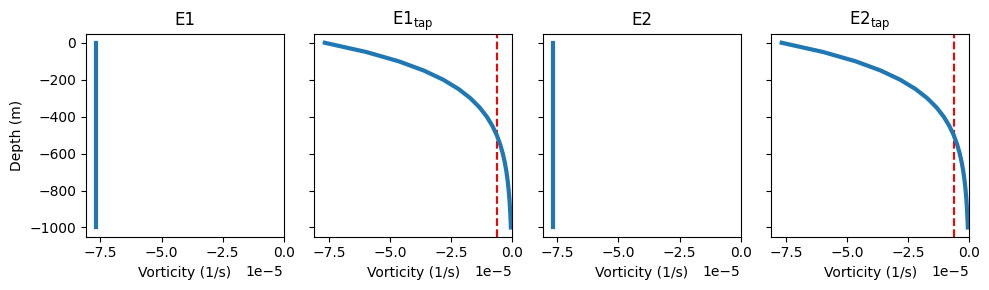

In [10]:

fig, axs = plt.subplots(1, 4, figsize=(10, 3), sharey=True)
xmin = 0
for ax, eddy in zip(axs.flatten(), eddies):
    df = plot_data[eddy]['df']
    ax.plot(df['Vort'], df['Depth'], linewidth=3)
    ax.set_title(modelled_data[eddy]['Name'])
    xmin = min(xmin, ax.get_xlim()[0])

VORT_THRESH = -0.000006
axs[1].axvline(x=VORT_THRESH, color='r', linestyle='--', zorder=0) 
axs[3].axvline(x=VORT_THRESH, color='r', linestyle='--', zorder=0) 

for ax in axs.flatten():
    ax.set_xlim(xmin, 0)
    ax.set_xlabel('Vorticity (1/s)')

axs[0].set_ylabel('Depth (m)')


fig.tight_layout()
plt.show()



In [11]:
plot_data['Eddy3']['df'].diff()

,n_xc,n_yc,xc,yc,Depth,Vort
0,NaN,NaN,NaN,NaN,NaN,NaN
1,5000.0,0.0,5000.0,0.0,-50.0,1.696391e-05
2,5000.0,0.0,5000.0,0.0,-50.0,1.321150e-05
3,5000.0,0.0,5000.0,0.0,-50.0,1.028913e-05
4,5000.0,0.0,5000.0,0.0,-50.0,8.013182e-06
5,5000.0,0.0,5000.0,0.0,-50.0,6.240673e-06
6,5000.0,0.0,5000.0,0.0,-50.0,4.860241e-06
7,5000.0,0.0,5000.0,0.0,-50.0,3.785159e-06
8,5000.0,0.0,5000.0,0.0,-50.0,2.947885e-06
9,5000.0,0.0,5000.0,0.0,-50.0,2.295815e-06
